- https://pypi.org/project/panel/#:~:text=Bind%20it%20to%20a%20Panel%20widget%20and%20lay,web%20server%20wrap%20it%20in%20a%20nice%20template

- https://panel.holoviz.org/how_to/notebook/notebook.html

- https://panel.holoviz.org/reference/layouts/Tabs.html

- https://panel.holoviz.org/how_to/layout/examples/dynamic_tabs.html

- https://learn.deeplearning.ai/courses/langchain-chat-with-your-data/lesson/7/chat

In [11]:
import panel as pn
import param

In [14]:
import ipywidgets as widgets
from IPython.display import display

# Create widgets for panel components
button1 = widgets.Button(description="Button 1")
button2 = widgets.Button(description="Button 2")
output = widgets.Output()

# Define callback functions for buttons
def on_button1_clicked(b):
    with output:
        print("Button 1 clicked")

def on_button2_clicked(b):
    with output:
        print("Button 2 clicked")

# Bind callback functions to button events
button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)

# Arrange widgets in a layout
panel = widgets.VBox([button1, button2, output])

# Display the panel
display(panel)

In [33]:
import panel as pn

pn.extension()

def calculate_power(wind_speed, efficiency):
    power_generation = wind_speed * efficiency
    return (
        f"Wind Speed: {wind_speed} m/s, "
        f"Efficiency: {efficiency}, "
        f"Power Generation: {power_generation:.1f} kW"
    )

wind_speed = pn.widgets.FloatSlider(
    value=5, start=0, end=20, step=1, name="Wind Speed (m/s)"
)
efficiency = pn.widgets.FloatInput(value=0.3, start=0.0, end=1.0, name="Efficiency (kW/(m/s))")

power = pn.bind(
    calculate_power, wind_speed=wind_speed, efficiency=efficiency
)

submit = pn.widgets.Button(name="Submit", button_type="primary")

def result(clicked):
    if clicked:
        return power()
    return "Click Submit"

result = pn.pane.Markdown(pn.bind(result, submit))

pn.Column(
    wind_speed, efficiency, submit, result
).servable()

Column
    [0] FloatSlider(end=20, name='Wind Speed (m/s)', step=1, value=5)
    [1] FloatInput(end=1.0, name='Efficiency (kW/(m/s))', start=0.0, value=0.3)
    [2] Button(button_type='primary', name='Submit')
    [3] Markdown(str)

In [92]:
import time
import panel as pn

pn.extension()

submit = pn.widgets.Button(name="Start the wind turbine")

def start_stop_wind_turbine(clicked):
    with submit.param.update(loading=True, disabled=True):
        time.sleep(2)
        if bool(submit.clicks%2):
            submit.name = "Start the wind turbine"
        else:
            submit.name = "Stop the wind turbine"

pn.bind(start_stop_wind_turbine, submit, watch=True)

pn.Column(submit).servable()

Column
    [0] Button(name='Start the wind turbine')

In [105]:
from time import sleep

import asyncio

import panel as pn

pn.extension()

submit = pn.widgets.Button(name="Start the wind turbine")

async def start_stop_wind_turbine(clicked):
    with submit.param.update(loading=True, disabled=True):
        result = await asyncio.to_thread(sleep, 5)

        if submit.clicks % 2:
            submit.name = "Start the wind turbine"
        else:
            submit.name = "Stop the wind turbine"

pn.bind(start_stop_wind_turbine, submit, watch=True)

pn.Column(submit).servable()

Column
    [0] Button(name='Start the wind turbine')

In [ ]:
def load_file(filename):
    if filename.value is not None:
        print("Reading csv...")
        df = pd.read_csv(filename)
        return f"File loaded successfully with {len(df)} rows and {len(df.columns)} columns"
    return "No file loaded"


file_widget = pn.widgets.FileInput(accept='.csv')

submit = pn.widgets.Button(name="Submit", button_type="primary")

filename = pn.bind(load_file, filename=file_widget)

def result(clicked):
    if clicked:
        return filename()
    return "Click Submit"


result = pn.pane.Markdown(pn.bind(result, submit))

pn.Column(
    file_widget, submit, result
).servable()

# async def result(event):
#     with submit.param.set(loading=True, disabled=True):
#         if file_widget.value is not None:
#             result_message = await asyncio.to_thread(load_file, file_widget.value)
#             return pn.pane.Markdown(result_message)
#         return pn.pane.Markdown("No file loaded. Please upload a file and click Submit.")

# # Bind the result function to the button click event
# submit.param.watch(result, 'clicks')

# # Create and serve the layout
# layout = pn.Column(
#     file_widget, submit, pn.bind(result, submit)
# )

# layout.servable()

In [205]:
!pip install graphviz
!pip install networkx

from graphviz import Graph
import networkx as nx
import panel as pn

# Create a Graphviz graph
hw = Graph('hello', format='svg')
hw.edge('Hello', 'World')

# Create a NetworkX graph
G = nx.cycle_graph(4, create_using=nx.DiGraph())

# Convert Graphviz graph to Panel SVG pane
hw_pane = pn.pane.SVG(hw.pipe(format='svg'))

# Convert NetworkX graph to Panel Bokeh plot
G_pane = pn.pane.Bokeh(nx.draw(G, with_labels=True, pos=nx.spring_layout(G)), height=400, width=400)

# Display the panes in a Panel Row layout
pn.Row(hw_pane, G_pane)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [206]:
import numpy as np
import panel as pn
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource

# Generate some sample data
x = np.linspace(0, 4*np.pi, 100)
y = np.sin(x)

# Create a Bokeh figure
plot = figure(title="Simple Sine Wave Plot", plot_width=600, plot_height=400)
plot.line(x, y, line_width=2)

# Create a Panel Bokeh pane
bokeh_pane = pn.pane.Bokeh(plot)

# Create a Panel app to display the Bokeh plot
app = pn.Column(
    '# Simple Bokeh Plot',
    bokeh_pane
)

# Display the app
app.servable()


AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [210]:
!pip install ipympl

  Obtaining dependency information for ipympl from https://files.pythonhosted.org/packages/d8/50/d6f4e7eb0e7d198b431d8259bc9a6035f879d4df487448b196cdf1e84155/ipympl-0.9.4-py3-none-any.whl.metadata
  Obtaining dependency information for ipython-genutils from https://files.pythonhosted.org/packages/fa/bc/9bd3b5c2b4774d5f33b2d544f1460be9df7df2fe42f352135381c347c69a/ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/516.3 kB ? eta -:--:--
    --------------------------------------- 10.2/516.3 kB ? eta -:--:--
   --------------- ------------------------ 204.8/516.3 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 516.3/516.3 kB 5.4 MB/s eta 0:00:00


Matplotlib(None, design=<class 'panel.theme.native...)

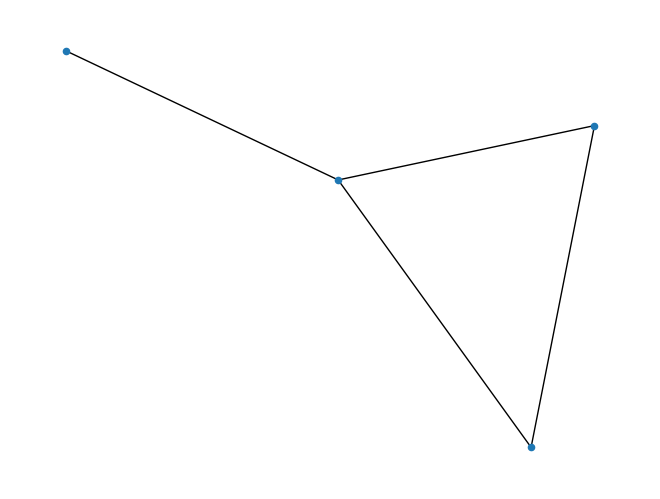

In [241]:
from matplotlib.figure import Figure

G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])
pos = nx.spring_layout(G)
fig = nx.draw(G, pos, with_labels=False, node_size=20, font_size=12)

app = pn.pane.Matplotlib(fig)
app.servable()

Column(design=<class 'panel.theme.native...)
    [0] Matplotlib(Figure, design=<class 'panel.theme.native...)
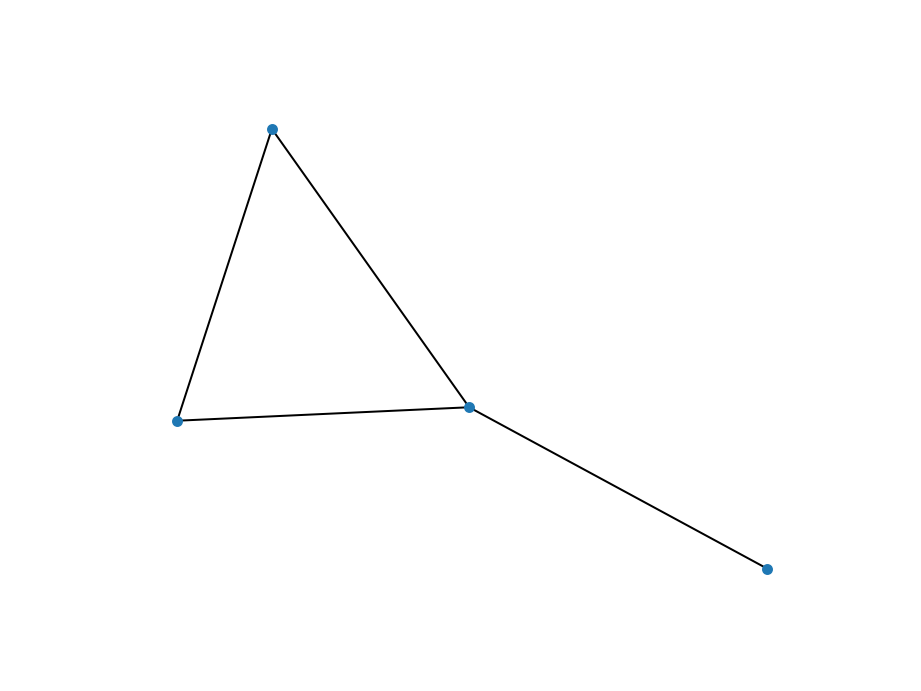

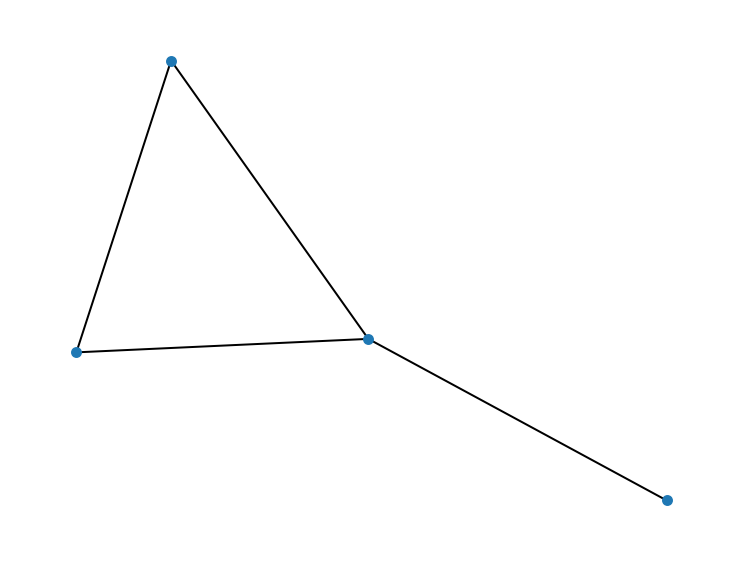

In [246]:
import networkx as nx
import panel as pn
import matplotlib.pyplot as plt

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])

# Compute the layout for the graph
pos = nx.spring_layout(G)

# Create a Matplotlib figure
fig, ax = plt.subplots()

# Draw the NetworkX graph on the Matplotlib axes
nx.draw(G, pos, ax=ax, with_labels=False, node_size=20, font_size=12)

# Create a Panel Matplotlib pane from the figure
pn.Column(pn.pane.Matplotlib(fig))


In [330]:
import pandas as pd

df = pd.read_csv('https://datasets.holoviz.org/penguins/v1/penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [332]:
import panel as pn

pn.extension('tabulator')

species_widget = pn.widgets.Select(name="species", options=["Adelie", "Gentoo", "Chinstrap"])
year_widget = pn.widgets.IntSlider(name="year", start=2007, end=2009)

In [333]:
import hvplot.pandas  # Enable interactive

idf = df.interactive()
idf = idf[(idf["species"] == species_widget) & (idf["year"] >= year_widget)]

idf.head()

In [334]:
idf.hvplot(kind="scatter", x="bill_length_mm", y="bill_depth_mm", by="sex")

# **CREATING THE FINAL PANEL**

In [1]:
import param
import panel as pn
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from bokeh.plotting import figure
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')
df_edges_init = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

In [3]:
class dashboard:
    def __init__(self, train_set, test_set, df_edges_init):
        self.train_set = train_set
        self.test_set = test_set
        self.df_edges_init = df_edges_init
        # self.output = pn.pane.Markdown('')
        
    def choose_configuration(self, timestep, model):
        if self.train_set[self.train_set["Time Step"] == timestep].empty:
            self.df_subgraph = self.test_set[self.test_set['Time Step'] == timestep]
        else:
            self.df_subgraph = self.train_set[self.train_set['Time Step'] == timestep]
        self.df_edges = self.df_edges_init.loc[(self.df_edges_init['txId1'].isin(self.df_subgraph['txId'])) & (self.df_edges_init['txId2'].isin(self.df_subgraph['txId']))]
        self.model = model

        # self.output.object = f"Timestep chosen: {timestep}, Model chosen: {self.model}"
        print(f"Timestep chosen: {timestep}, Model chosen: {self.model}")

        return self.train_model()

    def train_model(self):
        # self.output.object = "Training the model..."
        print("Training the model...")
        
        X_train = self.train_set.loc[self.train_set['class'].isin([1, 2])].drop(columns=['class'])
        y_train = self.train_set.loc[self.train_set['class'].isin([1, 2])]['class']
        
        X_test = self.test_set.loc[self.test_set['class'].isin([1, 2])].drop(columns=['class'])
        y_test = self.test_set.loc[self.test_set['class'].isin([1, 2])]['class']
        
        if self.model == 'Random Forest':
            chosen_model = RandomForestClassifier()

        chosen_model.fit(X_train, y_train)

        # Evaluate the model
        self.y_pred = chosen_model.predict(X_test)

        return (f"Successfully obtained predictions from {self.model} model!")


    def display_graph(self):
        # Create graph
        print("Creating the graph...")
        
        i = 0
        graph = nx.Graph()
        
        print("\nAdding nodes...\n")
        for _, row in self.df_subgraph.iterrows():
            # Extract node ID and attributes
            # print(i)
            node_id = row['txId']
            node_attributes = row.drop('txId').to_dict()
            
            # Add node to the graph with its attributes
            graph.add_node(node_id, **node_attributes)
            i+= 1
    
    
        print("\nAdding edges...\n")
        i=0
        for _, row in self.df_edges.iterrows():
            graph.add_edge(row['txId1'], row['txId2'])
            i+=1
            
        print("\nSuccessfully created the graph!")


        # Display graph
        print("Displaying the graph...")
        fig,ax=plt.subplots()
        # if node_type == "Ilicit":
        #     colors = {1: 'red'}
        # elif node_type== "Licit":
        #     colors = {2: 'green'}
        # elif node_type == "Unknown":
        #     colors = {3: 'black'}
        # else:
        colors = {1: 'red', 2: 'green', 3: 'black'}
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, ax=ax,with_labels=False, node_color=[colors[graph.nodes[n]['class']] for n in graph.nodes()], node_size=20, font_size=12)
        
        return fig


    def numerical_results(self):
        df_predictions = self.test_set[self.test_set['class'] != 3]
        df_predictions.insert(loc=2, column='prediction', value=self.y_pred)

        return df_predictions

db = dashboard(train_set, test_set, df_edges_init)

In [4]:
# Tab 2: choosing things
pn.extension('ipywidgets')

timestep_widget = pn.widgets.IntSlider(name="TimeStep", value=1, start=1, end=49)
model_widget = pn.widgets.Select(name="Models", options=["Random Forest", "GNN", "Autoencoders Embeddings", "Autoencoders Reconstruction"])
model_widget2 = pn.widgets.RadioButtonGroup(
    name="Models",
    options=["Random Forest", "GNN", "Autoencoders Embeddings", "Autoencoders Reconstruction"],
)

choices = pn.bind(db.choose_configuration, timestep=timestep_widget, model=model_widget2)

button_get_predictions = pn.widgets.Button(name="Get Prediction", button_type="primary")

def result(clicked):
    if clicked:
        return choices()
    # return "Click Get Predictions"

result = pn.pane.Markdown(pn.bind(result, button_get_predictions))

# pn.Column(
#     timestep_widget, model_widget2, submit, result
# ).servable()

pn.Column(
    pn.layout.Divider(),
    pn.Row(),
    pn.Row(model_widget2),
    pn.Row(),
    pn.Row(timestep_widget),
    pn.Row(),
    pn.Row(button_get_predictions, result),
    pn.Row(),
    pn.layout.Divider(),
)


Column
    [0] Divider()
    [1] Row()
    [2] Row
        [0] RadioButtonGroup(name='Models', options=['Random Forest', ...], value='Random Forest')
    [3] Row()
    [4] Row
        [0] IntSlider(end=49, name='TimeStep', start=1, value=1)
    [5] Row()
    [6] Row
        [0] Button(button_type='primary', name='Get Prediction')
        [1] Markdown(None)
    [7] Row()
    [8] Divider()

In [353]:
# Tab 3: visualizations
button_create_graph = pn.widgets.Button(name="Create graph", button_type="primary")
create_graph = pn.bind(db.display_graph)

def result(clicked):
    if clicked:
        return create_graph()

result = pn.bind(result, button_create_graph)


pn.Column(
    pn.layout.Divider(),
    pn.Row(),
    pn.Row(button_create_graph),
    pn.pane.Matplotlib(result),
    pn.layout.Divider(),
)

Column(design=<class 'panel.theme.native...)
    [0] Divider(design=<class 'panel.theme.native...)
    [1] Row(design=<class 'panel.theme.native...)
    [2] Row(design=<class 'panel.theme.native...)
        [0] Button(button_type='primary', design=<class 'panel.theme.native..., name='Create graph')
    [3] Matplotlib(None, design=<class 'panel.theme.native...)
    [4] Divider(design=<class 'panel.theme.native...)

In [344]:
# Tab 2: choosing things
button_results = pn.widgets.Button(name="Get Results", button_type="primary")
numerical_results = pn.bind(db.numerical_results)


def result(clicked):
    if clicked:
        return numerical_results()
    # return "Click Get Predictions"

result = pn.pane.Markdown(pn.bind(result, button_results))

# pn.Column(
#     timestep_widget, model_widget2, submit, result
# ).servable()

pn.Column(
    pn.layout.Divider(),
    pn.Row(button_results),
    pn.Row(result),
    pn.layout.Divider(),
)

Traceback (most recent call last):
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\pyviz_comms\__init__.py", line 340, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\panel\viewable.py", line 472, in _on_msg
 patch.apply_to_document(doc, comm.id if comm else None)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 104, in apply_to_document
 invoke_with_curdoc(doc, lambda: doc.apply_json_patch(self.payload, setter=setter))
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\callbacks.py", line 443, in invoke_with_curdoc
 return f()
 ^^^
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 104, in <lambda>
 invoke_with_curdoc(doc, lambda: doc.apply_json_patch(self.payload, setter=setter))
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\document.py", line 391, in apply_json_patch
 DocumentPatchedEvent.handle_event(self, event, setter)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\events.py", line 245, in handle_event
 event_cls._handle_event(doc, event)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\events.py", line 280, in _handle_event
 cb(event.msg_data)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\callbacks.py", line 390, in trigger_event
 model._trigger_event(event)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\util\callback_manager.py", line 113, in _trigger_event
 self.document.callbacks.notify_event(cast(Model, self), event, invoke)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\callbacks.py", line 260, in notify_event
 invoke_with_curdoc(doc, callback_invoker)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\document\callbacks.py", line 443, in invoke_with_curdoc
 return f()
 ^^^
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\bokeh\util\callback_manager.py", line 109, in invoke
 cast(EventCallbackWithEvent, callback)(event)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\panel\reactive.py", line 481, in _comm_event
 state._handle_exception(e)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\panel\io\state.py", line 442, in _handle_exception
 raise exception
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\panel\reactive.py", line 479, in _comm_event
 self._process_bokeh_event(doc, event)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\panel\reactive.py", line 416, in _process_bokeh_event
 self._process_event(event)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\panel\widgets\button.py", line 246, in _process_event
 self.param.trigger('value')
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 2440, in trigger
 self_.update(dict(params, **triggers))
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 2278, in update
 restore = self_._update(*args, **kwargs)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 2318, in _update
 self_._batch_call_watchers()
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 2509, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 2471, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 2006, in _sync_refs
 new_val = resolve_value(ref)
 ^^^^^^^^^^^^^^^^^^
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 180, in resolve_value
 value = eval_function_with_deps(value)
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 File "C:\Users\Usuario\anaconda3\Lib\site-packages\param\parameterized.py", line 162, in eval_function_with_deps
 return function(*args, **kwargs)
 ^^^^^^^^^^^^^^^^^^^^^^^^^
 File "C:\Users\Usuario\anaconda3

Column(design=<class 'panel.theme.native...)
    [0] Divider(design=<class 'panel.theme.native...)
    [1] Row(design=<class 'panel.theme.native...)
        [0] Button(button_type='primary', design=<class 'panel.theme.native..., name='Get Results')
    [2] Row(design=<class 'panel.theme.native...)
        [0] Markdown(None, design=<class 'panel.theme.native...)
    [3] Divider(design=<class 'panel.theme.native...)

In [336]:
# For tab 1: create buttons to enter the text and upload the file, also a button to clear the history
file_input = pn.widgets.FileInput(accept='.pkl')
button_load = pn.widgets.Button(name="Load file", button_type='primary')
# button_load.param.watch(interactions.load_file(), 'clicks')
# bound_button_load = pn.bind(interactions.load_file, button_load.param.clicks)

tab1 = pn.Column(
    pn.layout.Divider(),
    pn.Row(),
    pn.Row(file_input, button_load),
    pn.Row(),
    pn.Row(file_input.value),
    pn.layout.Divider(),
)


# Tab 2: Creating options for the user to choose from
timestep_widget = pn.widgets.IntSlider(name="TimeStep", value=30, start=1, end=49)
model_widget = pn.widgets.Select(name="Models", options=["Random Forest", "GNN", "Autoencoders Embeddings", "Autoencoders Reconstruction"])
model_widget2 = pn.widgets.RadioButtonGroup(
    name="Models",
    options=["Random Forest", "GNN", "Autoencoders Embeddings", "Autoencoders Reconstruction"],
).servable()

choices = pn.bind(db.choose_configuration, timestep=timestep_widget, model=model_widget2)

button_get_predictions = pn.widgets.Button(name="Get predictions", button_type="primary")

def result(clicked):
    if clicked:
        return choices()
    # return "Click Get Predictions"

result = pn.pane.Markdown(pn.bind(result, button_get_predictions))

# pn.Column(
#     timestep_widget, model_widget2, submit, result
# ).servable()

tab2 = pn.Column(
    pn.layout.Divider(),
    pn.Row(),
    pn.Row(model_widget2),
    pn.Row(),
    pn.Row(timestep_widget),
    pn.Row(),
    pn.Row(button_get_predictions, result),
    pn.Row(),
    pn.layout.Divider(),
)


# Tab 3: create visualizations of the original graph and the predicted graph
# Tab 3: visualizations
button_create_graph = pn.widgets.Button(name="Create graph", button_type="primary")
create_graph = pn.bind(db.display_graph)

def result(clicked):
    if clicked:
        return create_graph()

result = pn.bind(result, button_create_graph)


tab3 = pn.Column(
    pn.layout.Divider(),
    pn.Row(),
    pn.Row(button_create_graph),
    pn.pane.Matplotlib(result),
    pn.layout.Divider(),
)


# Tab 4: Display results (nº of real licit, ilicit and unknown nodes vs nº of predicted (table/plot))
tab4=pn.Column(
    pn.layout.Divider(),
)


# Unificate all the characteristics into a panel
panel_graph = pn.Column(pn.Row(pn.pane.Markdown('# Visualize Graphs')),
                        pn.Tabs(('Upload File', tab1), ('Model and Time Step', tab2), ('Visualizations', tab3),('Results', tab4)))
panel_graph

Timestep chosen: 30, Model chosen: Random Forest 
Training the model... 
Creating the graph... 
 
Adding nodes... 
 
 
Adding edges... 
 
 
Successfully created the graph! 
Displaying the graph...

Column(design=<class 'panel.theme.native...)
    [0] Row(design=<class 'panel.theme.native...)
        [0] Markdown(str, design=<class 'panel.theme.native...)
    [1] Tabs(design=<class 'panel.theme.native...)
        [0] Column(design=<class 'panel.theme.native...)
            [0] Divider(design=<class 'panel.theme.native...)
            [1] Row(design=<class 'panel.theme.native...)
            [2] Row(design=<class 'panel.theme.native...)
                [0] FileInput(accept='.pkl', design=<class 'panel.theme.native...)
                [1] Button(button_type='primary', design=<class 'panel.theme.native..., name='Load file')
            [3] Row(design=<class 'panel.theme.native...)
            [4] Row(design=<class 'panel.theme.native...)
                [0] Str(None, design=<class 'panel.theme.native...)
            [5] Divider(design=<class 'panel.theme.native...)
        [1] Column(design=<class 'panel.theme.native...)
            [0] Divider(design=<class 'panel.theme.native...)
            [1] Row(design=<class 'panel.theme.native...)
            [2] Row(design=<class 'panel.theme.native...)
                [0] RadioButtonGroup(design=<class 'panel.theme.native..., name='Models', options=['Random Forest', ...], value='Random Forest')
            [3] Row(design=<class 'panel.theme.native...)
            [4] Row(design=<class 'panel.theme.native...)
                [0] IntSlider(design=<class 'panel.theme.native..., end=49, name='TimeStep', start=1, value=30)
            [5] Row(design=<class 'panel.theme.native...)
            [6] Row(design=<class 'panel.theme.native...)
                [0] Button(button_type='primary', design=<class 'panel.theme.native..., name='Get predictions')
                [1] Markdown(None, design=<class 'panel.theme.native...)
            [7] Row(design=<class 'panel.theme.native...)
            [8] Divider(design=<class 'panel.theme.native...)
        [2] Column(design=<class 'panel.theme.native...)
            [0] Divider(design=<class 'panel.theme.native...)
            [1] Row(design=<class 'panel.theme.native...)
            [2] Row(design=<class 'panel.theme.native...)
                [0] Button(button_type='primary', design=<class 'panel.theme.native..., name='Create graph')
            [3] Matplotlib(None, design=<class 'panel.theme.native...)
            [4] Divider(design=<class 'panel.theme.native...)
        [3] Column(design=<class 'panel.theme.native...)
            [0] Divider(design=<class 'panel.theme.native...)

In [10]:
pn.serve(panel_graph)

Launching server at http://localhost:54510
